In [288]:
from sklearn.metrics import accuracy_score
import torch.nn.functional as F
import torchvision.models as models
import torch
import torchmetrics
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from torchvision import utils
import  torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

import glob
import cv2
import pandas as pd
import pyreadr
import numpy as np
import ntpath
import re
import time
from PIL import Image
import os
import pickle
import random
import math
from datetime import datetime

import matplotlib.pyplot as plt


from skimage.segmentation import mark_boundaries
from lime import lime_image
from captum.attr import Occlusion

In [35]:
mobilenetv3 = torch.load("mobilenetv3_best_susp.pth")
mobilenetv3.cpu()

MobileNetV3(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): ConvBNActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): Identity()
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=

# Visualizing conv filters

In [284]:
def visTensor(tensor, ch = 0, allkernels = False, nrow = 8, padding = 1): 
    n,c,w,h = tensor.shape

    if allkernels: tensor = tensor.view(n*c, -1, w, h)
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

    rows = np.min((tensor.shape[0] // nrow + 1, 64))    
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    plt.figure( figsize=(nrow,rows), dpi = 600 )
    plt.imshow(grid.cpu().numpy().transpose((1, 2, 0)))      

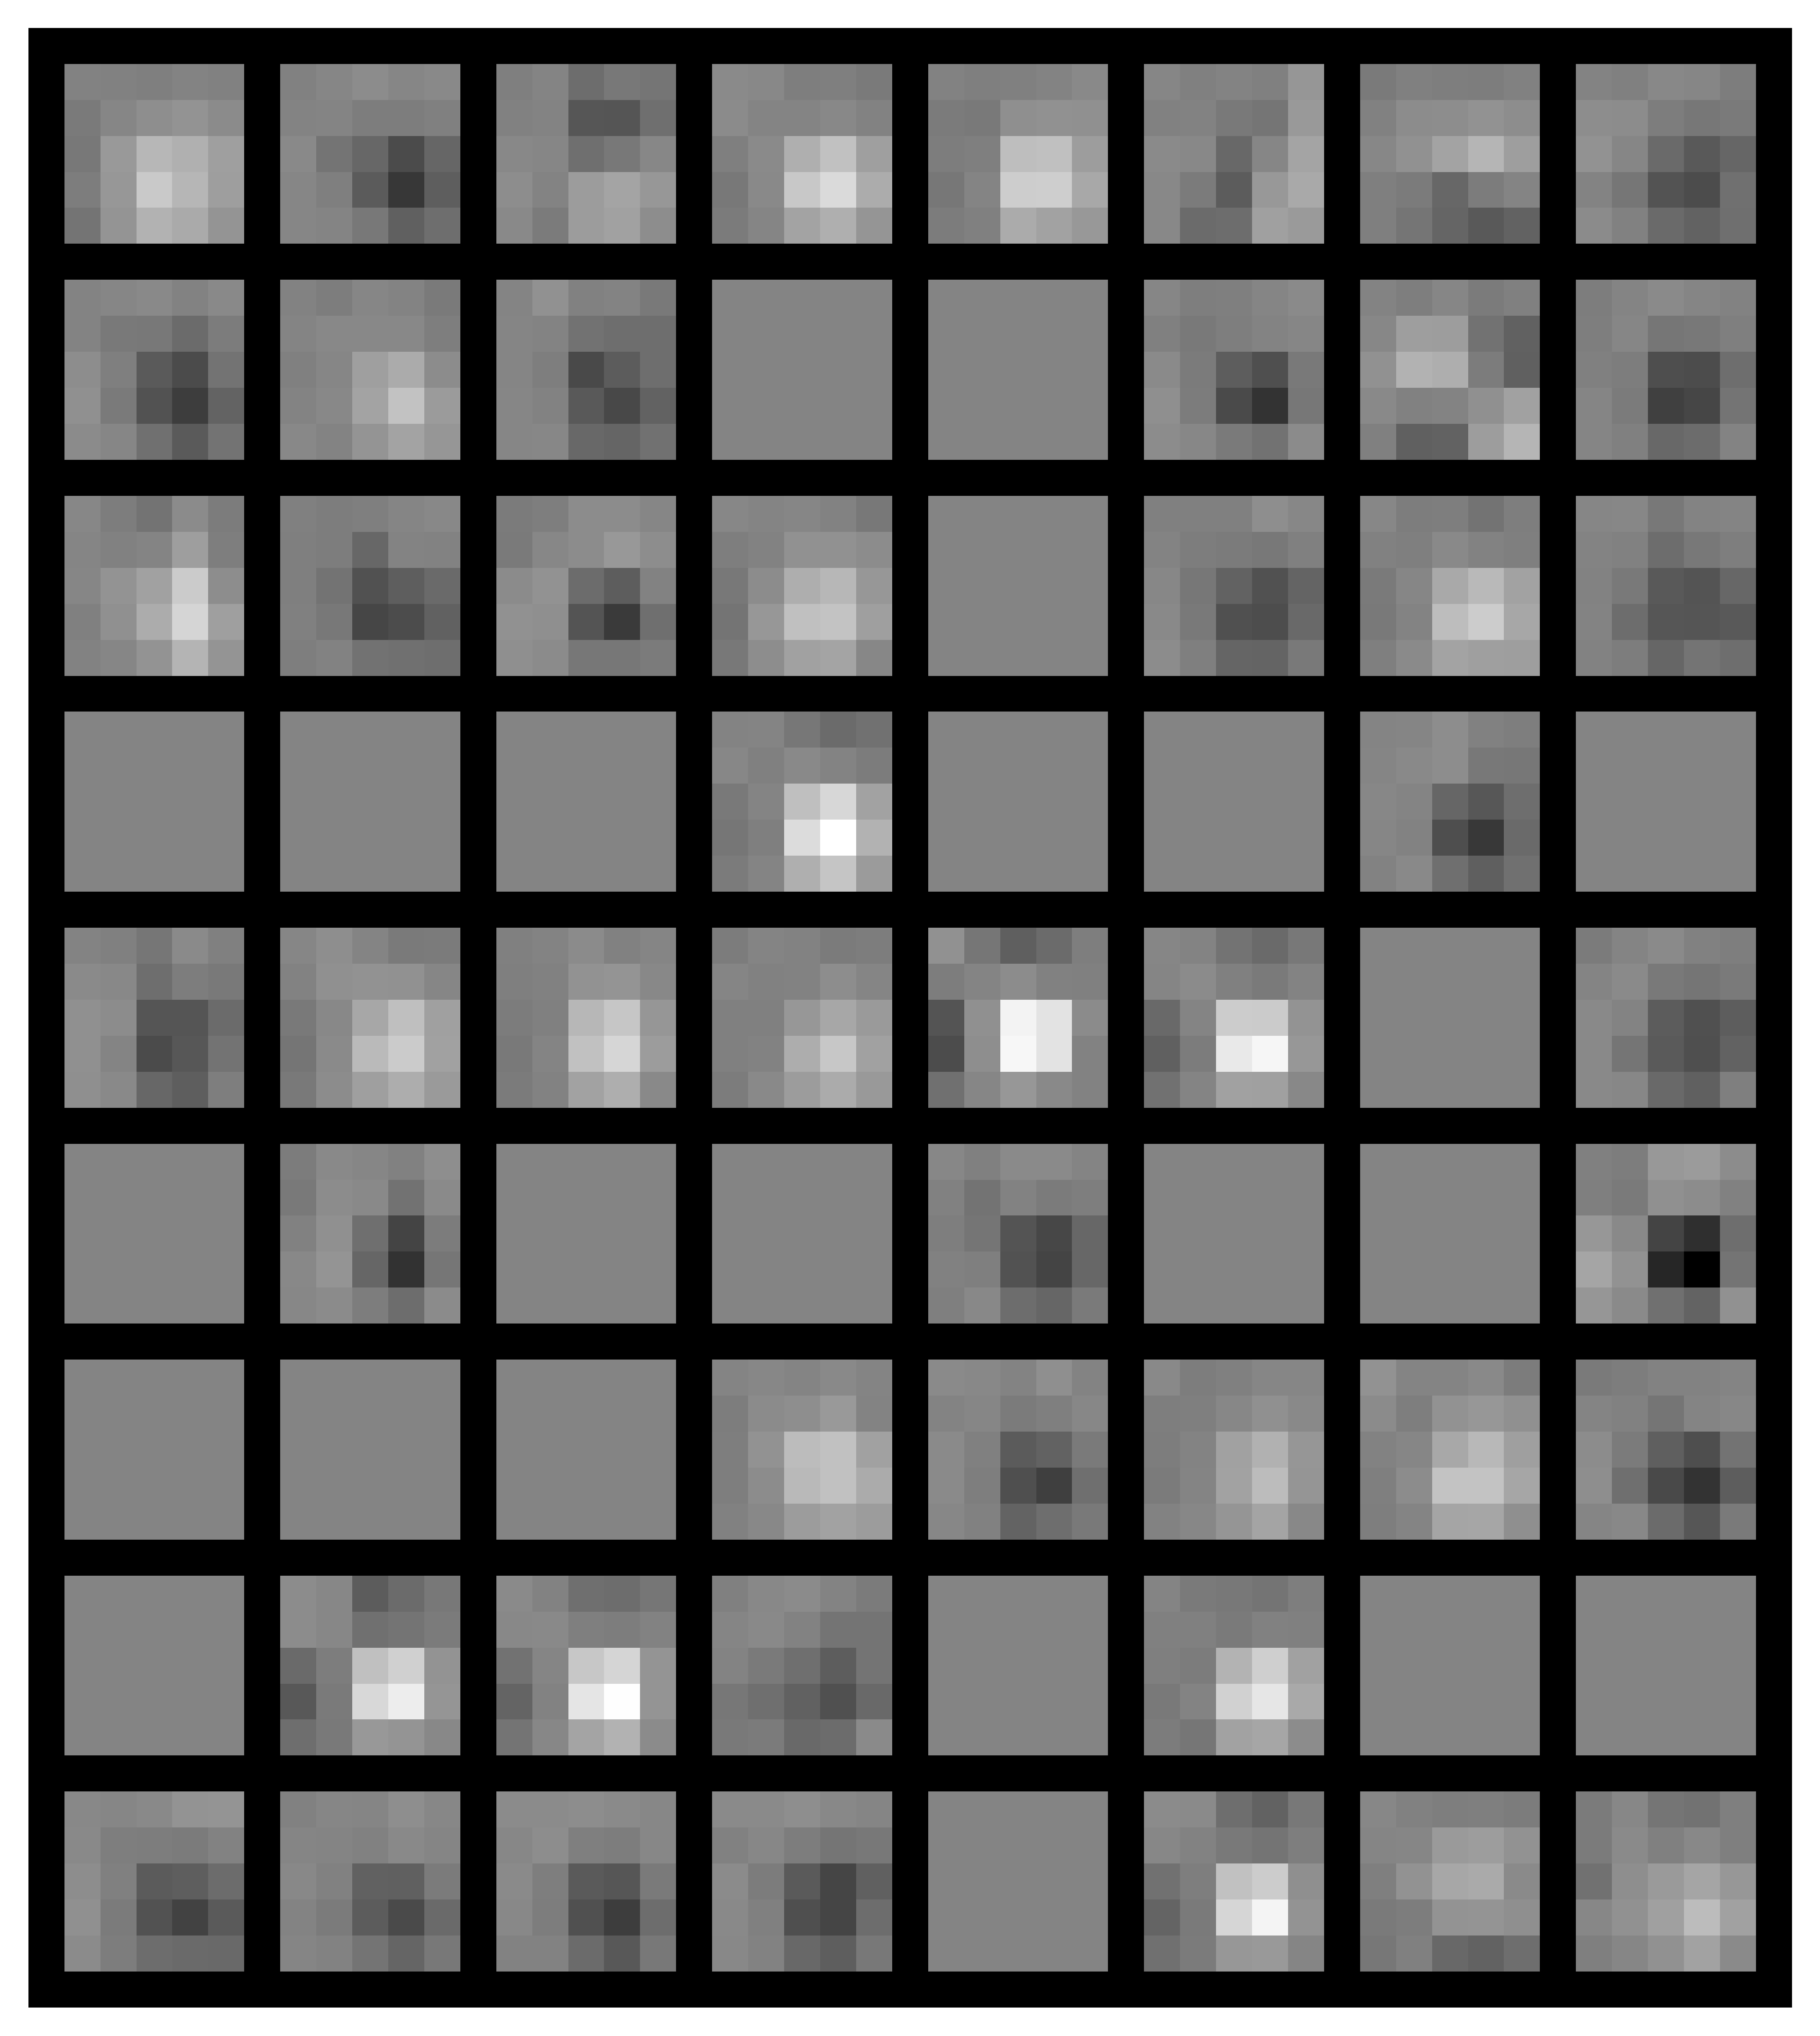

In [286]:
layer_num = 1
layer = dict(mobilenetv3.features[4].block.named_children())['1'][0].weight.data.clone()
visTensor(layer, ch = 0, allkernels = False)

plt.axis('off')
plt.ioff()
plt.show()

In [287]:
kernels = dict(mobilenetv3.features[4].block.named_children())['1'][0].weight.data.clone()

#check size for sanity check
print(kernels.size())

# normalize to (0,1) range so that matplotlib
# can plot them
kernels = kernels - kernels.min()
kernels = kernels / kernels.max()
filter_img = utils.make_grid(kernels, nrow = 8)
# change ordering since matplotlib requires images to 
# be (H, W, C)
plt.figure(figsize=(60,60), dpi = 200, facecolor = 'white')
plt.imshow(filter_img.permute(1, 2, 0))

torch.Size([72, 1, 5, 5])


In [242]:
dict(mobilenetv3.features[2].block.named_children())['1'][0]

Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=64, bias=False)

# Saliency maps

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


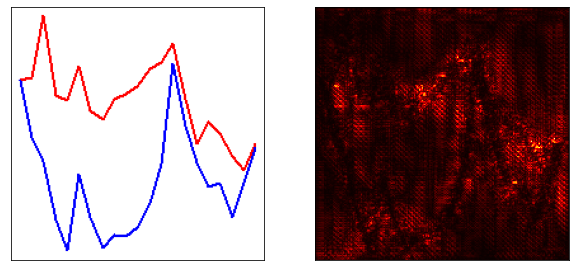

In [395]:
img = Image.open('/home/ext_kantek/wubp/img_data/img/wba-axp70.png').convert('RGB')
saliency(img, mobilenetv3.cpu())

In [65]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
#inverse transform to get normalize image back to original form for visualization
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)

#transforms to resize image to the size expected by pretrained model,
#convert PIL image to tensor, and
#normalize the image
transform = transforms.Compose([
#     transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize,          
])

In [47]:
def saliency(img, model):
    #we don't need gradients w.r.t. weights for a trained model
    for param in model.parameters():
        param.requires_grad = False
    
    #set model in eval mode
    model.eval()
    #transoform input PIL image to torch.Tensor and normalize
    input = transform(img)
    input.unsqueeze_(0)

    #we want to calculate gradient of higest score w.r.t. input
    #so set requires_grad to True for input 
    input.requires_grad = True
    #forward pass to calculate predictions
    preds = model(input)
    score, indices = torch.max(preds, 1)
    #backward pass to get gradients of score predicted class w.r.t. input image
    score.backward()
    #get max along channel axis
    slc, _ = torch.max(torch.abs(input.grad[0]), dim=0)
    #normalize to [0..1]
    slc = (slc - slc.min())/(slc.max()-slc.min())

    #apply inverse transform on image
    with torch.no_grad():
        input_img = inv_normalize(input[0])
    #plot image and its saleincy map
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(np.transpose(input_img.detach().numpy(), (1, 2, 0)))
    plt.xticks([])
    plt.yticks([])
    plt.subplot(1, 2, 2)
    plt.imshow(slc.numpy(), cmap=plt.cm.hot)
    plt.xticks([])
    plt.yticks([])
    plt.show()

# LIME

In [181]:
def batch_predict(images):
    mobilenetv3.eval()
    batch = torch.tensor(images, dtype=torch.float32).permute(0,3,1,2)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    mobilenetv3.to(device)
    batch = batch.to(device)
    
    probs = mobilenetv3(batch)
    
    return probs.detach().cpu().numpy()

In [396]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(transform(img).permute(1,2,0), dtype=np.double), 
                                         batch_predict, # classification function
                                         top_labels=1, 
                                         hide_color=0, 
                                         num_samples=1000) # number of images that will be sent to classification function

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


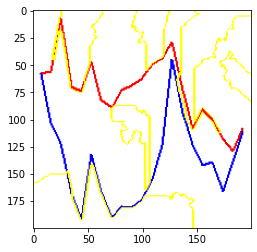

In [408]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=False)
img_boundry1 = mark_boundaries(temp, mask)
plt.imshow(img_boundry1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


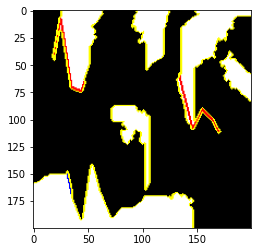

In [409]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=True)
img_boundry1 = mark_boundaries(temp, mask)
plt.imshow(img_boundry1)

In [416]:
plt.imshow(mask * np.array(inv_normalize(torch.tensor(temp).permute(2,0,1)).permute(1,2,0)))

ValueError: operands could not be broadcast together with shapes (200,200) (200,200,3) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


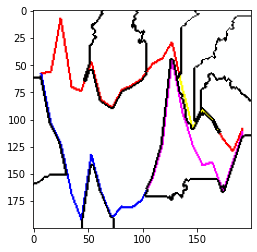

In [430]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries( np.array(inv_normalize(torch.tensor(temp).permute(2,0,1)).permute(1,2,0)), mask,  color=(0,0,0))
plt.imshow(img_boundry2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


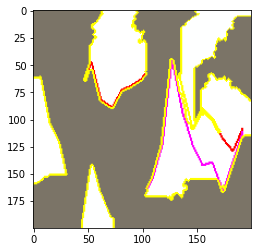

In [410]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=True)
img_boundry2 = mark_boundaries( np.array(inv_normalize(torch.tensor(temp).permute(2,0,1)).permute(1,2,0)), mask)
plt.imshow(img_boundry2)

In [142]:
torch.tensor(temp).permute(2,0,1).shape

torch.Size([3, 200, 200])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


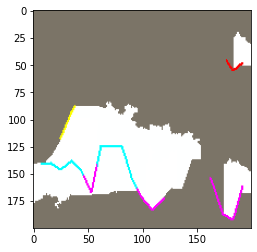

In [168]:
plt.imshow(inv_normalize(torch.tensor(temp).permute(2,0,1)).permute(1,2,0))

In [119]:
np.max(temp)

2.640000104904175

In [121]:
np.max(mask)

1

In [123]:
 (((temp-np.min(temp))/(np.max(temp)-np.min(temp)) - 0.5 ) *2)

array([[[0.83560332, 0.9111253 , 1.        ],
        [0.83560332, 0.9111253 , 1.        ],
        [0.83560332, 0.9111253 , 1.        ],
        ...,
        [1.        , 0.9111253 , 1.        ],
        [1.        , 0.9111253 , 1.        ],
        [1.        , 0.9111253 , 1.        ]],

       [[0.83560332, 0.9111253 , 1.        ],
        [0.83560332, 0.9111253 , 1.        ],
        [0.83560332, 0.9111253 , 1.        ],
        ...,
        [1.        , 0.9111253 , 1.        ],
        [1.        , 0.9111253 , 1.        ],
        [1.        , 0.9111253 , 1.        ]],

       [[0.83560332, 0.9111253 , 1.        ],
        [0.83560332, 0.9111253 , 1.        ],
        [0.83560332, 0.9111253 , 1.        ],
        ...,
        [1.        , 0.9111253 , 1.        ],
        [1.        , 0.9111253 , 1.        ],
        [1.        , 0.9111253 , 1.        ]],

       ...,

       [[0.83560332, 0.9111253 , 1.        ],
        [0.83560332, 0.9111253 , 1.        ],
        [0.83560332, 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


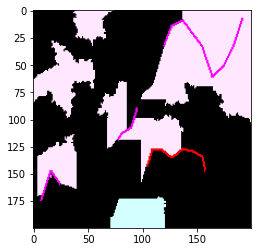

In [131]:
plt.imshow((((temp-np.min(temp))/(np.max(temp)-np.min(temp)) - 0.5 ) *2))

# Occlusion

In [293]:
transform(img).unsqueeze(0).shape

torch.Size([1, 3, 200, 200])

In [362]:
from captum.attr import Occlusion

occlusion = Occlusion(mobilenetv3.cuda())

strides = (3, 20, 20)              # smaller = more fine-grained attribution but slower
target = 0                
sliding_window_shapes = (3, 40, 40)  # choose size enough to change object appearance
baselines = 0                     # values to occlude the image with. 0 corresponds to gray

attribution_dog = occlusion.attribute(transform(img).unsqueeze(0).cuda(),
                                       strides = strides,
                                       target=target,
                                       sliding_window_shapes=sliding_window_shapes,
                                       baselines=baselines)


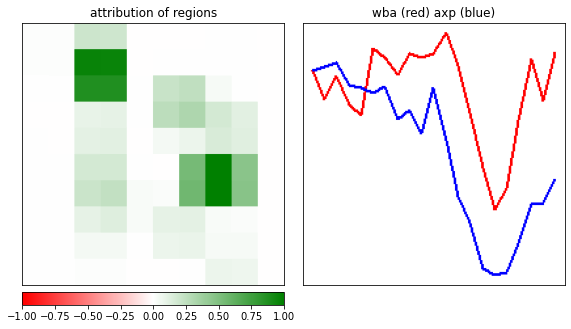

In [363]:
import numpy as np
from captum.attr import visualization as viz

attribution_dog = np.transpose(attribution_dog.squeeze().cpu().detach().numpy(), (1,2,0))

vis_types = ["heat_map", "original_image"]
vis_signs = ["all", "all"] 
_ = viz.visualize_image_attr_multiple(attribution_dog,
                                      np.array(img),
                                      vis_types,
                                      vis_signs,
                                      ["attribution of regions", "wba (red) axp (blue)"],
                                      show_colorbar = True
                                     )
